<a href="https://colab.research.google.com/github/diogo-dev/sentiment-analysis-financial-news/blob/main/SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pré-processamento das notícias contídas no arquivo csv

In [ ]:
!pip install spacy pandas

In [ ]:
import pandas as pd
# biblioteca de pln usada para a tokenização e lematização
import spacy
# biblioteca de expressões regulares
import re
from typing import List, Tuple

In [ ]:
!python -m spacy download pt_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 87.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# A lista de stopwords do modelo "pt_core_news_sm" do scapy é muito grande e contém alguns termos que podem interferir na análise
# O mesmo problema ocorre com a lista de stopwords da biblioteca nltk
# Ainda assim, a remoção de todas as stopwords não está perfeita
# Estou usando uma lista própria de stopwords, pois evita a remoção de termos que podem impactar a análise

stopwords_list = [
    # Artigos, preposições e conjunções
    "a", "à", "ao", "aos", "as", "às", "com", "como", "da", "das",
    "de", "dela", "dele", "deles", "delas", "depois", "do", "dos",
    "e", "é", "em", "entre", "era", "foi", "foram", "há", "já",
    "mais", "mas", "na", "nas", "não", "nem", "no", "num",
    "numa", "o", "os", "ou", "para", "pela", "pelas", "pelo", "pelos",
    "por", "quando", "que", "sem", "só", "também",

    # Pronomes pessoais
    "me", "te", "se", "nos", "vos",
    "eu", "tu", "ele", "ela", "nós", "vós", "eles", "elas",
    "lhe", "lhes", "você", "vocês",

    # Possessivos
    "meu", "meus", "minha", "minhas",
    "teu", "teus", "tua", "tuas",
    "seu", "seus", "sua", "suas",
    "nosso", "nossos", "nossa", "nossas",

    # Demonstrativos
    "esse", "essa", "esses", "essas",
    "este", "esta", "estes", "estas",
    "isso", "isto",
    "aquele", "aquela", "aqueles", "aquelas", "aquilo",

    # Indefinidos
    "alguém", "ninguém", "nada", "tudo", "cada",
    "outro", "outra", "outros", "outras",
    "algum", "alguma", "alguns", "algumas",
    "nenhum", "nenhuma",
    "certo", "certa", "certos", "certas",
    "tal", "tais",
    "mesmo", "mesmos", "mesmas",

    # Relativos
    "quem", "qual", "quais",
    "cujo", "cuja", "cujos", "cujas",
    "onde",

    # Interrogativos
    "quanto", "quanta", "quantos", "quantas"
]

stopwords_set = set(stopwords_list)

In [ ]:
class NewsPreprocessor:
  # função de inicialização da classe
  def __init__(self):
    # inicializa o preprocessador ao carregar o modelo do spacy
    try:
      self.nlp = spacy.load("pt_core_news_sm")
    except OSError:
            print("ERRO: Modelo 'pt_core_news_sm' não encontrado!")
            raise

  def clean_text(self, text) -> str:
    # Limpa o texto removendo caracteres especiais e normalizando

    if pd.isna(text) or text == '':
      return ''

    # Remove quebras de linha e tabs
    text = re.sub(r'\n+', ' ', text)
    text = re.sub(r'\t+', ' ', text)

    # Remove múltiplos espaços
    text = re.sub(r'\s+', ' ', text)

    # Remove caracteres especiais mantendo apenas letras, números e espaços
    text = re.sub(r'[^\w\s]', ' ', text)

    return text.strip()

  def preprocess_text(self, text) -> Tuple[List[str], str]:
    # processa o texto fazendo a remoção de stopwords e também a lematização
    # retorno: tupla: (lista de tokens processados, texto processado como string)

    if pd.isna(text) or text == '':
            return [], ''

    # Limpa o texto
    cleaned_text = self.clean_text(text)

    if not cleaned_text:
        return [], ''

    # Processa com spaCy (transformação do cleaned_text em objeto Doc do spacy)
    # Isso permite acessar informações do texto sobre os tokens, lemmas, entidades e mais.
    doc = self.nlp(cleaned_text)

    # Extrai tokens: remove stop words, pontuação, espaços e faz lematização
    processed_tokens = []
    for token in doc:
        # Ignora stopwords, pontuação, espaços e tokens muito curtos
        if (token.text.lower() not in stopwords_set and
            not token.is_punct and
            not token.is_space and
            len(token.text) > 2 and
            token.text.isalpha()):  # Mantém apenas palavras (sem números)

            # Adiciona o lema em minúsculo
            processed_tokens.append(token.lemma_.lower())

    # Remove duplicatas mantendo a ordem
    processed_tokens = list(dict.fromkeys(processed_tokens))

    return processed_tokens, ' '.join(processed_tokens)

  def process_csv(self, file_path: str) -> pd.DataFrame:
    # lendo o arquivo csv de entrada (contém as notícias a serem pré-processadas)
    df = pd.read_csv(file_path, encoding='utf-8')

    # Cria novas colunas para os dados processados
    df['conteudo_tokens'] = None
    df['conteudo_processado'] = None

    # inicio do pré-processamento
    # processa linha por linha
    for index, row in df.iterrows():
      # processa conteúdo
      conteudo_tokens, conteudo_proc = self.preprocess_text(row['conteudo'])
      df.at[index, 'conteudo_tokens'] = conteudo_tokens
      df.at[index, 'conteudo_processado'] = conteudo_proc

    # fim do pré-processamento
    return df

  def show_preprocessing_examples(self, df: pd.DataFrame, num_examples: int = 3):
      # Mostra exemplos do pré-processamento
      print(f"\n=== EXEMPLOS DE PRÉ-PROCESSAMENTO ===")

      for i in range(min(num_examples, len(df))):
          print(f"\n--- NOTÍCIA {i + 1} ---")

          # Conteúdo original vs processado (primeiros 200 caracteres)
          conteudo_orig = str(df.iloc[i]['conteudo'])[:200] + "..."
          print(f"\nCONTEÚDO ORIGINAL (primeiros 200 chars):")
          print(f"'{conteudo_orig}'")

          conteudo_proc = str(df.iloc[i]['conteudo_processado'])[:200] + "..."
          print(f"\nCONTEÚDO PROCESSADO (primeiros 200 chars):")
          print(f"'{conteudo_proc}'")

          print(f"TOKENS DO CONTEÚDO (primeiros 10): {df.iloc[i]['conteudo_tokens'][:10]}")
          print("-" * 80)

In [ ]:
# Com a classe de pré-processamento criada, vamos criar a função principal
def main():
  preprocessor = NewsPreprocessor()

  file_path = "/content/noticias_petrobras_2024.csv"

  try:
    df_processed = preprocessor.process_csv(file_path)

    # Mostra exemplos
    preprocessor.show_preprocessing_examples(df_processed, num_examples=3)

    # Salva o resultado processado
    df_processed.to_csv("noticias_preprocessadas_2023.csv", index=False, encoding='utf-8')

  except Exception as e:
    print(f"Erro ao processar o arquivo csv: {e}")

if __name__ == "__main__":
  main()


=== EXEMPLOS DE PRÉ-PROCESSAMENTO ===

--- NOTÍCIA 1 ---

CONTEÚDO ORIGINAL (primeiros 200 chars):
'A Petrobras ( PETR3 ; PETR4 ) notificou a Vibra ( VBBR3 ) que não pretende renovar nos termos atuais o acordo de licenciamento de marcas ao final do contrato em junho de 2029, segundo comunicados envi...'

CONTEÚDO PROCESSADO (primeiros 200 chars):
'petrobras notificar vibra pretender renovar termo atual acordo licenciamento marca final contrato junho segundo comunicado enviar mercado em este quarto feira afirmar decisão gerar qualquer mudança es...'
TOKENS DO CONTEÚDO (primeiros 10): ['petrobras', 'notificar', 'vibra', 'pretender', 'renovar', 'termo', 'atual', 'acordo', 'licenciamento', 'marca']
--------------------------------------------------------------------------------

--- NOTÍCIA 2 ---

CONTEÚDO ORIGINAL (primeiros 200 chars):
'A Petrobras ( PETR4 ) recebeu nesta quarta-feira US$ 298 milhões referentes à última parcela da venda do Polo Carmópolis , em Sergipe, mostra documento 

# Modelo de Dicionário LM

## 1: Vamos fazer a tradução do dicionário
1.   Criar uma lista das palavras positivas e negativas
2.   Fazer a lematização dessas palavras
3.   Utilizar um api para a tradução
4.   Verificar se a tradução ficou consistente

In [ ]:
# carregando o dicionário a partir de seu arquivo csv
lm_dict = pd.read_csv("/content/Loughran-McDonald_MasterDictionary_1993-2024.csv")
lm_dict

,Word,Seq_num,Word Count,Word Proportion,Average Proportion,Std Dev,Doc Count,Negative,Positive,Uncertainty,Litigious,Strong_Modal,Weak_Modal,Constraining,Complexity,Syllables,Source
0,AARDVARK,1,755,2.955070e-08,1.945421e-08,4.078069e-06,140,0,0,0,0,0,0,0,0,2,12of12inf
1,AARDVARKS,2,3,1.174200e-10,8.060019e-12,8.919011e-09,1,0,0,0,0,0,0,0,0,2,12of12inf
2,ABACI,3,9,3.522600e-10,1.089343e-10,5.105359e-08,7,0,0,0,0,0,0,0,0,3,12of12inf
3,ABACK,4,29,1.135060e-09,6.197922e-10,1.539279e-07,28,0,0,0,0,0,0,0,0,2,12of12inf
4,ABACUS,5,9620,3.765268e-07,3.825261e-07,3.421836e-05,1295,0,0,0,0,0,0,0,0,3,12of12inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86548,ZYGOTE,86529,74,2.896360e-09,1.319060e-09,2.920362e-07,49,0,0,0,0,0,0,0,0,2,12of12inf
86549,ZYGOTES,86530,1,3.914000e-11,1.685075e-11,1.864660e-08,1,0,0,0,0,0,0,0,0,2,12of12inf
86550,ZYGOTIC,86531,0,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0,0,0,0,0,0,0,3,12of12inf
86551,ZYMURGIES,86532,0,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0,0,0,0,0,0,0,3,12of12inf


In [ ]:
# Criando a lista de palavras positivas e negativas presentes no dicionário
positive_words = lm_dict[lm_dict['Positive'] != 0]['Word'].str.lower().tolist()
negative_words = lm_dict[lm_dict['Negative'] != 0]['Word'].str.lower().tolist()

print(f"Número de palavras positivas presente no dicionário: {len(positive_words)}")
print(f"Número de palavras negativas presente no dicionário: {len(negative_words)}")

print(positive_words[:10])
print(negative_words[:10])

Número de palavras positivas presente no dicionário: 354
Número de palavras negativas presente no dicionário: 2355
['able', 'abundance', 'abundant', 'acclaimed', 'accomplish', 'accomplished', 'accomplishes', 'accomplishing', 'accomplishment', 'accomplishments']
['abandon', 'abandoned', 'abandoning', 'abandonment', 'abandonments', 'abandons', 'abdicated', 'abdicates', 'abdicating', 'abdication']


In [ ]:
# Vamos fazer a lematização das listas
import spacy

nlp = spacy.load("en_core_web_sm")

def lematizar_lista(palavras):
    # junta as palavras da lista para depois criar o objeto Doc do spacy
    texto = " ".join(palavras)
    doc = nlp(texto)

    lemas = [token.lemma_.lower() for token in doc if not token.is_space]
    return list(set(lemas))

positive_words_lemma = lematizar_lista(positive_words)
negative_words_lemma = lematizar_lista(negative_words)

print(f"Positivas: {len(positive_words)} → {len(positive_words_lemma)}")
print(f"Negativas: {len(negative_words)} → {len(negative_words_lemma)}")

print(sorted(positive_words_lemma))
print(sorted(negative_words_lemma))

Positivas: 354 → 232
Negativas: 2355 → 1382
['able', 'abundance', 'abundant', 'acclaim', 'accomplish', 'accomplished', 'accomplishment', 'achieve', 'achievement', 'achieves', 'adequately', 'advance', 'advancement', 'advantage', 'advantageous', 'advantageously', 'alliance', 'assure', 'attain', 'attainment', 'attractive', 'attractiveness', 'beautiful', 'beautifully', 'beneficial', 'beneficially', 'benefit', 'bolster', 'boom', 'boost', 'breakthrough', 'brilliant', 'charitable', 'collaborate', 'collaboration', 'collaborative', 'collaborator', 'compliment', 'complimentary', 'conclusive', 'conclusively', 'conducive', 'confident', 'constructive', 'constructively', 'courteous', 'creative', 'creatively', 'creativeness', 'creativity', 'delight', 'delightful', 'delightfully', 'dependability', 'dependable', 'desirable', 'desire', 'despite', 'destine', 'diligent', 'diligently', 'distinction', 'distinctive', 'distinctively', 'distinctiveness', 'dream', 'easier', 'easily', 'easy', 'effective', 'effic

In [ ]:
!pip install deepl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.8 MB/s eta 0:00:00


In [ ]:
# Agora vamos fazer a tradução com a api do deepL
import deepl
import time
# usando minha chave api para fazer as requisições
auth_key = "693d8062-4fc7-4814-9405-6c8ecbc1b317:fx"
# instanciando o tradutor
translator = deepl.Translator(auth_key)

palavras_positivas = {}
palavras_negativas = {}

# traduzindo as palavras positivas
for i, word in enumerate(positive_words_lemma):
  try:
    translation = translator.translate_text(
        word,
        source_lang="EN",
        target_lang="PT-BR",
        context="financial markets, accounting, corporate finance"
    )
    palavras_positivas[word] = translation.text.lower()

    if i < len(positive_words_lemma) - 1:
      time.sleep(1)

  except Exception as e:
    print(f"Erro na palavra {word}: {e}")

# traduzindo as palavras negativas
for i, word in enumerate(negative_words_lemma):
  try:
    translation = translator.translate_text(
        word,
        source_lang="EN",
        target_lang="PT-BR",
        context="financial markets, accounting, corporate finance"
    )
    palavras_negativas[word] = translation.text.lower()

    if i < len(positive_words_lemma) - 1:
      time.sleep(1)

  except Exception as e:
    print(f"Erro na palavra {word}: {e}")

# printando o resultado
print("=== 10 primeiros termos POSITIVOS ===")
for chave, valor in list(palavras_positivas.items())[:10]:
    print(chave, valor)
print("=== 10 primeiros termos NEGATIVOS ===")
for chave, valor in list(palavras_negativas.items())[:10]:
    print(chave, valor)

=== 10 primeiros termos POSITIVOS ===
excellence excelência
desire desejo
adequately adequadamente
exceptionally excepcionalmente
exclusivity exclusividade
transparency transparência
happiness felicidade
proficiently com proficiência
stronger mais forte
favorably favoravelmente
=== 10 primeiros termos NEGATIVOS ===
disturbance perturbação
suspicious suspeito
calamitous calamitoso
turbulence turbulência
disapprove desaprovar
mistake erro
danger perigo
unlawfully ilegalmente
harshly severamente
uncompetitive não competitivo


In [ ]:
# Salvando as palavras traduzidas em um arquivo csv
# Converte cada dicionário em DataFrame com uma coluna de tipo
df_pos = pd.DataFrame(list(palavras_positivas.items()), columns=["original", "traducao"])
df_pos["sentimento"] = "positivo"

df_neg = pd.DataFrame(list(palavras_negativas.items()), columns=["original", "traducao"])
df_neg["sentimento"] = "negativo"

# Contatena os dataFrames
df_final = pd.concat([df_pos, df_neg], ignore_index=True)

# Salvando o resultado em um arquivo csv
df_final.to_csv("dicionario_traduzido.csv", index=False, encoding="utf-8-sig")

## 2: Pontuação de Sentimento (Sentiment Score)

É a soma dos sentimentos das palavras que o texto que análise contém.

Passos dessa etapa:

1. Carregar o dicionário traduzido
2. Criar duas lista com os dados do dicionário (palavras positivas e palavras negativas)
3. Contar a quantidade de palavras positivas e nagativas por notícia
4. Calcular a pontuação através dessa contagem

In [ ]:
# carregando o dicionário já traduzido
lm_dict = pd.read_csv("/content/dicionario_traduzido.csv")
lm_dict.head()

,original,traducao,sentimento
0,grew,cresceu,positivo
1,grow,crescer,postivo
2,growth,crescimento,postivo
3,increased,aumentou,positivo
4,increase,aumentar,positivo


In [ ]:
# criando duas listas com as palavras positivas e outra com as palavras negativas
palavras_positivas = lm_dict[lm_dict['sentimento'] == 'positivo']['traducao'].tolist()
palavras_negativas = lm_dict[lm_dict['sentimento'] == 'negativo']['traducao'].tolist()

# transformar a lista em um set faz a busca ficar mais eficiente, mas aparentemente tem palavras que estão sendo excluídas.
# Ou seja, há palavras repetidas no dicionário traduzido. Verificar o dicionário para tentar mitigar essa problemática
from collections import Counter

# Contar todas as ocorrências
contagem = Counter(palavras_positivas)

# Pegar apenas os elementos que aparecem mais de uma vez
repetidos = [palavra for palavra, freq in contagem.items() if freq > 1]

print(repetidos)

['satisfatório']


In [ ]:
# biblioteca Abstract Syntax Trees
# responsável por converter ["conteudo_tokens"] de volta para um lista python
import ast

# carregando o arquivo das notícias processadas
news_df = pd.read_csv(
    "/content/noticias_preprocessadas_2024.csv",
    converters= {
        'conteudo_tokens': ast.literal_eval
    }
)
news_df.tail()

,url,titulo,data,conteudo,site,conteudo_tokens,conteudo_processado
742,https://www.infomoney.com.br/mercados/petrobra...,"Petrobras pagou R$ 240,2 bilhões em tributos e...",26/3/2024 12:48,Publicidade\nA Petrobras ( PETR3 ; PETR4 ) inf...,Infomoney,"[publicidade, petrobras, informar, em este, te...",publicidade petrobras informar em este terça f...
743,https://www.infomoney.com.br/mercados/petrobra...,Petrobras vende ativos e reativa fábrica de fe...,18/4/2024 07:24,Publicidade\nO radar corporativo desta quinta-...,Infomoney,"[publicidade, radar, corporativo, de este, qui...",publicidade radar corporativo de este quinta f...
744,https://www.infomoney.com.br/mercados/petrobra...,Petrobras presta esclarecimentos sobre possíve...,8/3/2024 08:14,"Publicidade\nA Petrobras ( PETR4 ) disse, em r...",Infomoney,"[publicidade, petrobras, dizer, resposta, ques...",publicidade petrobras dizer resposta questiona...
745,https://www.infomoney.com.br/mercados/petrobra...,"Petrobras quer dividir gestão na Braskem, não ...",20/2/2024 14:43,Publicidade\nRIO DE JANEIRO (Reuters) – A Petr...,Infomoney,"[publicidade, rio, janeiro, reuters, petrobra,...",publicidade rio janeiro reuters petrobra ter e...
746,https://www.infomoney.com.br/mercados/petrobra...,Petrobras: analistas revisam projeções para aç...,29/10/2024 09:06,Publicidade\nA Petrobras ( PETR3 ; PETR4 ) div...,Infomoney,"[publicidade, petrobras, divulgar, dado, produ...",publicidade petrobras divulgar dado produção v...


In [ ]:
# nesse trecho de código dá para verificar que a remoção das stopwords não está perfeita
print(type(news_df["conteudo_tokens"].iloc[0]))
lista1 = news_df["conteudo_tokens"].iloc[1]
lista2 = news_df["conteudo_processado"].iloc[1].split()

# comparando as duas listas
print(lista1 == lista2)
print(lista1)
print(lista2)

diff1 = set(lista1) - set(lista2)
diff2 = set(lista2) - set(lista1)

diffTotalc= diff1.union(diff2)
print(diffTotalc)

<class 'list'>
False
['petrobras', 'receber', 'em este', 'quarto', 'feira', 'milhão', 'referente', 'último', 'parcela', 'venda', 'polo', 'carmópolis', 'sergipe', 'mostrar', 'documento', 'enviar', 'mercado', 'dezembro', 'empresa', 'haver', 'comunicar', 'pagamento', 'vender', 'afiliada', 'grupo', 'espanhol', 'cobra', 'carmo', 'energy', 'um', 'operação', 'somar', 'bilhão', 'compreender', 'concessão', 'produção', 'terrestre', 'inclui', 'ainda', 'acesso', 'infraestrutura', 'processamento', 'escoamento', 'armazenamento', 'transporte', 'petróleo', 'gás', 'natural', 'fazer', 'parte', 'ativo', 'atalaia', 'contémr', 'terminal', 'aquaviário', 'aracaju', 'tecarmo', 'oleoduto', 'bonsucesso', 'escoa', 'óleo', 'até']
['petrobras', 'receber', 'em', 'este', 'quarto', 'feira', 'milhão', 'referente', 'último', 'parcela', 'venda', 'polo', 'carmópolis', 'sergipe', 'mostrar', 'documento', 'enviar', 'mercado', 'dezembro', 'empresa', 'haver', 'comunicar', 'pagamento', 'vender', 'afiliada', 'grupo', 'espanhol'

In [ ]:
# criando uma coluna para a quantidade de tokens presente em cada noticia
news_df["num_token"] = news_df["conteudo_tokens"].apply(len)

# contando a quantidade de palavras positivas por notícia
news_df["num_pos"] = news_df["conteudo_tokens"].apply(
    lambda tokens: sum(1 for token in tokens if token in palavras_positivas))

# contando a quantidade de palavras negativas por notícia
news_df["num_neg"] = news_df["conteudo_tokens"].apply(
    lambda tokens: sum(1 for token in tokens if token in palavras_negativas))

news_df.head()

,url,titulo,data,conteudo,site,conteudo_tokens,conteudo_processado,num_token,num_pos,num_neg
0,https://www.moneytimes.com.br/petrobras-petr4-...,Petrobras (PETR4) não pretende renovar acordo ...,10/01/2024 09:22,A Petrobras ( PETR3 ; PETR4 ) notificou a Vibr...,Money Times,"[petrobras, notificar, vibra, pretender, renov...",petrobras notificar vibra pretender renovar te...,56,1,0
1,https://www.moneytimes.com.br/caiu-o-pix-petro...,Caiu o PIX: Petrobras (PETR4) embolsa US$ 298 ...,10/01/2024 20:33,A Petrobras ( PETR4 ) recebeu nesta quarta-fei...,Money Times,"[petrobras, receber, em este, quarto, feira, m...",petrobras receber em este quarto feira milhão ...,62,0,0
2,https://www.moneytimes.com.br/petrobras-petr4-...,Petrobras (PETR4): Refinaria Rnest vai faturar...,18/01/2024 19:57,"A Refinaria Abreu e Lima (Rnest) , da Petrobra...",Money Times,"[refinaria, abreu, lima, rnest, petrobras, ir,...",refinaria abreu lima rnest petrobras ir fatura...,61,0,1
3,https://www.moneytimes.com.br/efrain-da-cruz-r...,Efrain da Cruz renuncia ao conselho da Petrobr...,21/01/2024 13:38,Efrain Pereira da Cruz renunciou ao cargo de c...,Money Times,"[efrain, pereira, cruz, renunciar, cargo, cons...",efrain pereira cruz renunciar cargo conselheir...,160,4,7
4,https://www.moneytimes.com.br/petrobras-petr4-...,Petrobras (PETR4) manifesta ao governo interes...,24/01/2024 20:04,A Petrobras ( PETR4 ) manifestou nesta quarta-...,Money Times,"[petrobras, manifestar, em este, quarto, feira...",petrobras manifestar em este quarto feira cons...,85,2,1


In [ ]:
# calcular a pontuação de sentimento das notícias
news_df["lm_diff"] = news_df["num_pos"] - news_df["num_neg"]

#news_df["lm_score1"] = (news_df["num_pos"] - news_df["num_neg"]) / news_df["num_token"]

# Calculate lm_score2 using a vectorized approach to avoid division by zero
news_df.loc[(news_df["num_pos"] + news_df["num_neg"]) != 0, "lm_score"] = (news_df["num_pos"] - news_df["num_neg"]) / (news_df["num_pos"] + news_df["num_neg"])

# para linha em que a soma de num_pos + num_neg é zero, atribuir 0 para lm_score2
news_df.loc[(news_df["num_pos"] + news_df["num_neg"]) == 0, "lm_score"] = 0

# aplicando um valor de corte para calcular o sentimento
CUTOFF = 0.3
news_df["lm_sentimento"] = news_df["lm_score"].apply(
    lambda x: "positivo" if x > CUTOFF else "negativo" if x < -CUTOFF else "neutro"
)

news_df

,url,titulo,data,conteudo,site,conteudo_tokens,conteudo_processado,num_token,num_pos,num_neg,lm_diff,lm_score,lm_sentimento
0,https://www.moneytimes.com.br/petrobras-petr4-...,Petrobras (PETR4) não pretende renovar acordo ...,10/01/2024 09:22,A Petrobras ( PETR3 ; PETR4 ) notificou a Vibr...,Money Times,"[petrobras, notificar, vibra, pretender, renov...",petrobras notificar vibra pretender renovar te...,56,1,0,1,1.000000,positivo
1,https://www.moneytimes.com.br/caiu-o-pix-petro...,Caiu o PIX: Petrobras (PETR4) embolsa US$ 298 ...,10/01/2024 20:33,A Petrobras ( PETR4 ) recebeu nesta quarta-fei...,Money Times,"[petrobras, receber, em este, quarto, feira, m...",petrobras receber em este quarto feira milhão ...,62,0,0,0,0.000000,neutro
2,https://www.moneytimes.com.br/petrobras-petr4-...,Petrobras (PETR4): Refinaria Rnest vai faturar...,18/01/2024 19:57,"A Refinaria Abreu e Lima (Rnest) , da Petrobra...",Money Times,"[refinaria, abreu, lima, rnest, petrobras, ir,...",refinaria abreu lima rnest petrobras ir fatura...,61,0,1,-1,-1.000000,negativo
3,https://www.moneytimes.com.br/efrain-da-cruz-r...,Efrain da Cruz renuncia ao conselho da Petrobr...,21/01/2024 13:38,Efrain Pereira da Cruz renunciou ao cargo de c...,Money Times,"[efrain, pereira, cruz, renunciar, cargo, cons...",efrain pereira cruz renunciar cargo conselheir...,160,4,7,-3,-0.272727,neutro
4,https://www.moneytimes.com.br/petrobras-petr4-...,Petrobras (PETR4) manifesta ao governo interes...,24/01/2024 20:04,A Petrobras ( PETR4 ) manifestou nesta quarta-...,Money Times,"[petrobras, manifestar, em este, quarto, feira...",petrobras manifestar em este quarto feira cons...,85,2,1,1,0.333333,positivo
...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,https://www.infomoney.com.br/mercados/petrobra...,"Petrobras pagou R$ 240,2 bilhões em tributos e...",26/3/2024 12:48,Publicidade\nA Petrobras ( PETR3 ; PETR4 ) inf...,Infomoney,"[publicidade, petrobras, informar, em este, te...",publicidade petrobras informar em este terça f...,64,1,0,1,1.000000,positivo
743,https://www.infomoney.com.br/mercados/petrobra...,Petrobras vende ativos e reativa fábrica de fe...,18/4/2024 07:24,Publicidade\nO radar corporativo desta quinta-...,Infomoney,"[publicidade, radar, corporativo, de este, qui...",publicidade radar corporativo de este quinta f...,202,4,5,-1,-0.111111,neutro
744,https://www.infomoney.com.br/mercados/petrobra...,Petrobras presta esclarecimentos sobre possíve...,8/3/2024 08:14,"Publicidade\nA Petrobras ( PETR4 ) disse, em r...",Infomoney,"[publicidade, petrobras, dizer, resposta, ques...",publicidade petrobras dizer resposta questiona...,45,2,1,1,0.333333,positivo
745,https://www.infomoney.com.br/mercados/petrobra...,"Petrobras quer dividir gestão na Braskem, não ...",20/2/2024 14:43,Publicidade\nRIO DE JANEIRO (Reuters) – A Petr...,Infomoney,"[publicidade, rio, janeiro, reuters, petrobra,...",publicidade rio janeiro reuters petrobra ter e...,168,2,4,-2,-0.333333,negativo


In [ ]:
# Salvando arquivo processado
news_df.to_csv("noticias_processadas_2024.csv", index=False, decimal = ",", float_format="%.6f")

# Modelo de Machine Learning (xlm-roBERTa)

## Aplicando o Fine-tuning no modelo base

### Para isso, fizemos o uso de um dataset de treinamento encontrado na plataforma kaggle: https://www.kaggle.com/datasets/mateuspicanco/financial-phrase-bank-portuguese-translation

In [ ]:
# instalando e importando as bibliotecas necessarias
!pip install evaluate transformers accelerate
# bibliotecas da Hugging Face
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)
import evaluate
# Outras bibliotecas auxiliares
import numpy as np
import pandas as pd
import torch
from sklearn.utils.class_weight import compute_class_weight

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.1 MB/s eta 0:00:00


In [ ]:
# carregando o dataset de treinamento
train_df = pd.read_csv("/content/financial_phrase_bank_pt_br.csv")

In [ ]:
# verificando a distribuição das classes (positivo, negativo e neutro)
print("Distribuição da classe:")
print(train_df["y"].value_counts())
print(f"Dataset size: {len(train_df)}")
print(f"\nDistrubuição em porcentagem")
print(train_df["y"].value_counts() / len(train_df))

Distribuição da classe:
y
neutral     2878
positive    1363
negative     604
Name: count, dtype: int64
Dataset size: 4845

Distrubuição em porcentagem
y
neutral     0.594014
positive    0.281321
negative    0.124665
Name: count, dtype: float64


In [ ]:
# Mapping sentiments to integer values
labels_map = {"negative": 0, "neutral": 1, "positive": 2}
train_df["label"] = train_df["y"].map(labels_map)

# Dictionary for label conversion
id2label = {0: "negative", 1: "neutral", 2: "positive"}
label2id = {"negative": 0, "neutral": 1, "positive": 2}

# Converting DataFrame to HuggingFace dataset
dataset = Dataset.from_pandas(train_df[["text_pt", "label"]])

# Cast the 'label' column to ClassLabel
from datasets import ClassLabel, Features, Value
features = Features({
    "text_pt": Value("string"),
    "label": ClassLabel(num_classes=3, names=["negative", "neutral", "positive"])
})
dataset = dataset.cast(features)

# Quebrar os dados com estratificação para manter o balanceamento das classes
#dataset = dataset.train_test_split(test_size=0.2, seed=42, stratify_by_column="label")
#print(dataset)

# 1ª divisão: separar test do resto
dataset_split = dataset.train_test_split(
    test_size=0.2,
    seed=42,
    stratify_by_column="label"
)

# 2ª divisão: separar validação do treino
train_valid = dataset_split["train"].train_test_split(
    test_size=0.1,   # aqui pega 10% do treino para validação
    seed=42,
    stratify_by_column="label"
)

# Reorganizar em um DatasetDict com train/val/test
dataset = {
    "train": train_valid["train"],
    "validation": train_valid["test"],
    "test": dataset_split["test"]
}

print(dataset)

Casting the dataset:   0%|          | 0/4845 [00:00<?, ? examples/s]

{'train': Dataset({
    features: ['text_pt', 'label'],
    num_rows: 3488
}), 'validation': Dataset({
    features: ['text_pt', 'label'],
    num_rows: 388
}), 'test': Dataset({
    features: ['text_pt', 'label'],
    num_rows: 969
})}


In [ ]:
# Criando as variáveis a partir da divisão do dataset original
train_labels = np.array(dataset["train"]["label"])
test_labels = np.array(dataset["test"]["label"])
validation_labels = np.array(dataset["validation"]["label"])

# Verificando a distrubuição da divisão do dataset
print(f"Train class distribution: {np.bincount(train_labels)}")
print(f"Test class distribution: {np.bincount(test_labels)}")
print(f"Validation class distribution: {np.bincount(validation_labels)}")

Train class distribution: [ 435 2072  981]
Test class distribution: [121 575 273]
Validation class distribution: [ 48 231 109]


In [ ]:
# Configurando o modelo
model_name = "xlm-roberta-base"

# Carregar tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Carregar o modelo
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,
    id2label=id2label,
    label2id=label2id,
    problem_type="single_label_classification"
)

# Criando o data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# fazendo a tokenização do texto de entrada (transformando o texto em números para serem processados pelo modelo)
def tokenize_function(examples):
    return tokenizer(
        examples["text_pt"],
        truncation=True,
        padding=False,  # Padding vai ser gerenciado pelo data collator
        max_length=512,
        return_attention_mask=True
    )

# Apply tokenization to each dataset split in the dictionary
tokenized_data = {
    split: dataset[split].map(tokenize_function, batched=True, remove_columns=["text_pt"])
    for split in dataset.keys()
}

Map:   0%|          | 0/3488 [00:00<?, ? examples/s]

Map:   0%|          | 0/388 [00:00<?, ? examples/s]

Map:   0%|          | 0/969 [00:00<?, ? examples/s]

In [ ]:
# Calculate class weights for imbalanced dataset
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print(f"Class weights: {class_weights_dict}")

Class weights: {0: np.float64(2.6727969348659), 1: np.float64(0.5611325611325612), 2: np.float64(1.1851851851851851)}


In [ ]:
# Custom trainer with class weights
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # Apply class weights
        weight_tensor = torch.tensor([class_weights_dict[i] for i in range(len(class_weights_dict))], dtype=torch.float, device=labels.device)

        loss_fct = torch.nn.CrossEntropyLoss(weight=weight_tensor)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

In [ ]:
# adicionar as métricas a serem calculadas durante o treinamento (usando biblioteca evaluate)
accuracy = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Calculate metrics
    acc = accuracy.compute(predictions=predictions, references=labels)
    prec = precision.compute(predictions=predictions, references=labels, average="weighted")
    rec = recall.compute(predictions=predictions, references=labels, average="weighted")
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")

    return {
        "accuracy": acc["accuracy"],
        "precision": prec["precision"],
        "recall": rec["recall"],
        "f1": f1["f1"]
    }

In [ ]:
# definindo os hiperparâmetros de treinamento
training_args = TrainingArguments(
    output_dir="./xlm-roberta-finetuned-sentiment",
    overwrite_output_dir=True,
    learning_rate=2e-5,  # Lower learning rate
    per_device_train_batch_size=16,  # Larger batch size if memory allows
    per_device_eval_batch_size=16,
    num_train_epochs=5,  # Fewer epochs with early stopping
    weight_decay=0.01,  # Add regularization
    warmup_steps=500,   # Learning rate warmup
    logging_steps=50,
    logging_strategy="steps",
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to=None,
    seed=42,
    dataloader_drop_last=False,
    push_to_hub=False,
)

In [ ]:
# treinando o modelo
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]

/tmp/ipython-input-3518431416.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


In [ ]:
# Treinando o modelo
trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: diogofelipe-dev (diogofelipe-dev-universidade-estadual-de-maring-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,1.099600,1.083797,0.409794,0.608253,0.409794,0.381146


KeyboardInterrupt: 

In [ ]:
# Evaluate the model
print("Final evaluation:")
results = trainer.evaluate()
print(results)

Final evaluation:


{'eval_loss': 0.42871570587158203, 'eval_accuracy': 0.8586171310629515, 'eval_precision': 0.8650909184798278, 'eval_recall': 0.8586171310629515, 'eval_f1': 0.8600839590763759, 'eval_runtime': 3.7565, 'eval_samples_per_second': 257.954, 'eval_steps_per_second': 16.239, 'epoch': 5.0}


In [ ]:
# salvando o modelo já treinado
trainer.save_model("./xlm-reberta-finetuned")
tokenizer.save_pretrained("./xlm-reberta-finetuned")

('./xlm-reberta-finetuned/tokenizer_config.json',
 './xlm-reberta-finetuned/special_tokens_map.json',
 './xlm-reberta-finetuned/sentencepiece.bpe.model',
 './xlm-reberta-finetuned/added_tokens.json',
 './xlm-reberta-finetuned/tokenizer.json')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# salvando o modelo no meu google drive
!cp -r ./xlm-roberta-finetuned /content/drive/MyDrive/

## Utilizando o Modelo Treinado

In [ ]:
import pandas as pd
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model_path = "/content/drive/MyDrive/xlm-roberta-finetuned"

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

In [ ]:
# pipeline de classificação
sentiment_classifier = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    return_all_scores=False,
    max_length = 512,
    truncation=True
)

Device set to use cuda:0
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
# teste para alisar o classificador. Fazer testes com textos das coluna "conteudo" e "conteudo_processado"
text = ''''''
resultado = sentiment_classifier(text)
print(resultado)

[{'label': 'positive', 'score': 0.8860442638397217}]


In [ ]:
# lendo arquivo csv que contém as notícias a serem rotuladas
df = pd.read_csv("noticias_processadas_2024.csv")
df.head()

,url,titulo,data,conteudo,site,conteudo_tokens,conteudo_processado,num_token,num_pos,num_neg,lm_diff,lm_score,lm_sentimento
0,https://www.moneytimes.com.br/petrobras-petr4-...,Petrobras (PETR4) não pretende renovar acordo ...,10/01/2024 09:22,A Petrobras ( PETR3 ; PETR4 ) notificou a Vibr...,Money Times,"['petrobras', 'notificar', 'vibra', 'pretender...",petrobras notificar vibra pretender renovar te...,56,1,0,1,"1,000000",positivo
1,https://www.moneytimes.com.br/caiu-o-pix-petro...,Caiu o PIX: Petrobras (PETR4) embolsa US$ 298 ...,10/01/2024 20:33,A Petrobras ( PETR4 ) recebeu nesta quarta-fei...,Money Times,"['petrobras', 'receber', 'em este', 'quarto', ...",petrobras receber em este quarto feira milhão ...,62,0,0,0,"0,000000",neutro
2,https://www.moneytimes.com.br/petrobras-petr4-...,Petrobras (PETR4): Refinaria Rnest vai faturar...,18/01/2024 19:57,"A Refinaria Abreu e Lima (Rnest) , da Petrobra...",Money Times,"['refinaria', 'abreu', 'lima', 'rnest', 'petro...",refinaria abreu lima rnest petrobras ir fatura...,61,0,1,-1,"-1,000000",negativo
3,https://www.moneytimes.com.br/efrain-da-cruz-r...,Efrain da Cruz renuncia ao conselho da Petrobr...,21/01/2024 13:38,Efrain Pereira da Cruz renunciou ao cargo de c...,Money Times,"['efrain', 'pereira', 'cruz', 'renunciar', 'ca...",efrain pereira cruz renunciar cargo conselheir...,160,4,7,-3,"-0,272727",neutro
4,https://www.moneytimes.com.br/petrobras-petr4-...,Petrobras (PETR4) manifesta ao governo interes...,24/01/2024 20:04,A Petrobras ( PETR4 ) manifestou nesta quarta-...,Money Times,"['petrobras', 'manifestar', 'em este', 'quarto...",petrobras manifestar em este quarto feira cons...,85,2,1,1,"0,333333",positivo


In [ ]:
# classificando as notícias com o uso do modelo
df["xlm_sentimento"] = df["conteudo"].apply(lambda x: sentiment_classifier(str(x))[0]['label'])
df["xlm_score"] = df["conteudo"].apply(lambda x: sentiment_classifier(str(x))[0]['score'])

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [ ]:
# salvando as notícias classificadas
df.to_csv("noticias_final_2024.csv", index=False, decimal = ",", float_format="%.6f")

#Análise de Correlação

## Modelo Dicionário

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

In [ ]:
# 1) carregar CSV (ajuste nome do arquivo)
fn = "noticias_final_2023.csv"
df = pd.read_csv(fn, encoding='utf-8', decimal=',')

# excluindo colunas do outro modelo
df = df.drop(columns=['num_token', 'num_pos', 'num_neg', 'lm_diff', 'xlm_score', 'xlm_sentimento'])

In [ ]:
# 2) converter coluna 'data' para datetime
df['datetime'] = pd.to_datetime(df['data'], dayfirst=True, errors='coerce')
df = df.dropna(subset=['datetime'])

In [ ]:
# 3) Converter sentimento categórico -> numérico
mapper = {"positivo": 1, "negativo": -1, "neutro": 0}
df["lm_sentiment_num"] = df["lm_sentimento"].str.lower().map(mapper)

In [ ]:
# 4) baixar preços PETR3 e PETR4 de 2020
tickers = ["PETR3.SA", "PETR4.SA"]
prices = yf.download(tickers, start="2023-01-01", end="2023-12-31", progress=False, auto_adjust=False)["Adj Close"]

# retornos diários (pct_change -> calcula a variação percentual diária nos preços)
returns = prices.pct_change().dropna()
returns = returns.rename(columns={c: c.replace(".SA","")+"_ret" for c in returns.columns})

In [ ]:
# 5) criar coluna 'date' para agregação diária
df['date'] = df['datetime'].dt.normalize()

# 6) Extrair o calendário de pregão
trading_days = returns.index

# 7) descartar notícias que tenho depois do último dia do pregão do ano para não dar erro na reatrubuição das datas das notícias
df = df[df['date'] <= trading_days.max()]

# 8) Reatribuir cada data de notícia para o próximo dia de pregão
# Essa linha só altera as datas que não coincidem com pregão. Se a notícia já caiu em um dia de mercado aberto, a data permanece igual
df['date_trading'] = df['date'].apply(lambda d: trading_days[trading_days >= d][0])

In [ ]:
# 8) agregar métricas de sentimento por dia
daily = df.groupby('date_trading').agg(
    mean_lm_sentiment=('lm_sentiment_num','mean'),
    pos_ratio=('lm_sentiment_num', lambda x: (x>0).sum()/len(x)),
    neg_ratio=('lm_sentiment_num', lambda x: (x<0).sum()/len(x)),
    neutral_ratio=('lm_sentiment_num', lambda x: (x==0).sum()/len(x)),
    mean_lm_score=('lm_score','mean'),
    count_news=('titulo','count')
)

daily['count_news'].sum()

np.int64(0)

In [ ]:
# 9) unir sentimentos com retornos
# Se em algum dia de pregão não teve nenhuma notícia, esse dia não estará em daily, e não vai aparecer no merged
merged = daily.join(returns, how='inner')
merged.head()

,mean_lm_sentiment,pos_ratio,neg_ratio,neutral_ratio,mean_lm_score,count_news,PETR3_ret,PETR4_ret
date_trading,,,,,,,,


In [ ]:
# 10) Função para a correlação
def pearson_report(x, y):
    mask = x.notna() & y.notna()
    if mask.sum() < 3:
        return np.nan, np.nan
    r, p = pearsonr(x[mask], y[mask])
    return r, p

In [ ]:
def correlation_by_period(df, sentiment_col, return_cols, period='Q', lag=0):
    """
    Calcula correlação por período

    Parameters:
    -----------
    df : DataFrame com índice datetime
    sentiment_col : nome da coluna de sentimento
    return_cols : lista de colunas de retorno
    period : 'Q' (trimestre), 'M' (mês), 'Y' (ano)
    lag : int (número de períodos de defasagem nos retornos em relação ao sentimento)
          - lag=0: correlação no mesmo dia
          - lag=1: retorno do dia seguinte em relação ao sentimento atual
          - lag=-1: retorno do dia anterior em relação ao sentimento atual
    """
    df = df.copy()

    # Se o índice não for datetime, tenta converter
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)

    results = []

    for col in return_cols:
        for period_label, group in df.groupby(pd.Grouper(freq=period)):

            # aplica a defasagem
            shifted_returns = group[col].shift(-lag) if lag != 0 else group[col]

            # remove NaNs criados pelo shift
            valid = group[[sentiment_col]].join(shifted_returns).dropna()

            if len(valid) > 1:  # precisa de pelo menos 2 pontos para correlação
                r, p = pearson_report(valid[sentiment_col], valid[col])
            else:
                r, p = None, None

            results.append({
                'periodo': period_label,
                'acao': col,
                'correlacao': r,
                'p_valor': p,
                'n_observacoes': len(group),
                'num_noticias': group['count_news'].sum(),
                'lag': lag
            })

    return pd.DataFrame(results)

# a coluna 'n_observacoes' é o número de dias de pregão (trading days) em que houve pelo menos uma notícia

In [ ]:
# Usar a função
results_df = correlation_by_period(
    merged,
    'mean_lm_sentiment',
    ['PETR3_ret', 'PETR4_ret'],
    period='Q',  # 'Q'=trimestre, 'M'=mês, 'Y'=ano
    lag=1
)

results_df

/tmp/ipython-input-2371825933.py:25: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  for period_label, group in df.groupby(pd.Grouper(freq=period)):
/tmp/ipython-input-2371825933.py:25: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  for period_label, group in df.groupby(pd.Grouper(freq=period)):


,periodo,acao,correlacao,p_valor,n_observacoes,num_noticias,lag
0,2020-03-31,PETR3_ret,-0.169003,0.213073,57,163,1
1,2020-06-30,PETR3_ret,0.116199,0.407341,54,179,1
2,2020-09-30,PETR3_ret,-0.178024,0.202188,54,209,1
3,2020-12-31,PETR3_ret,0.126031,0.373311,53,158,1
4,2020-03-31,PETR4_ret,-0.189988,0.160771,57,163,1
5,2020-06-30,PETR4_ret,0.064229,0.647731,54,179,1
6,2020-09-30,PETR4_ret,-0.149490,0.285352,54,209,1
7,2020-12-31,PETR4_ret,0.113496,0.423058,53,158,1


/tmp/ipython-input-1544462496.py:5: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  news_by_month = merged.groupby(pd.Grouper(freq='Q'))['count_news'].sum()


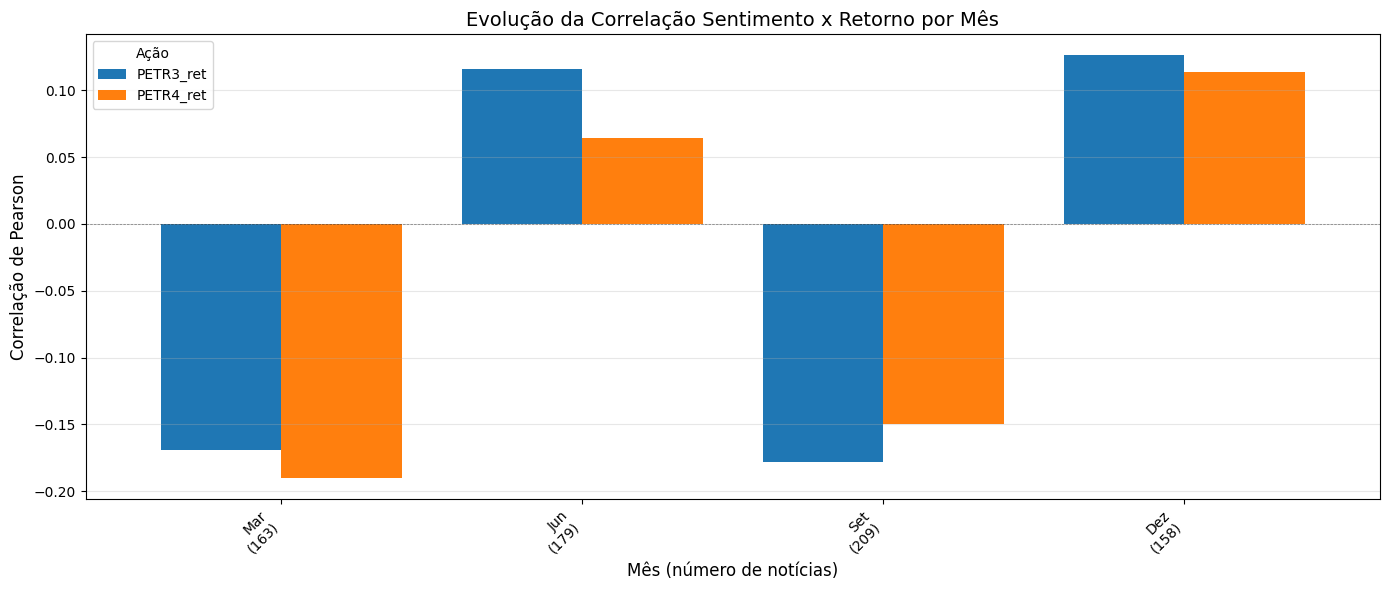


=== Correlações Estatisticamente Significativas (p < 0.05) ===
Empty DataFrame
Columns: [periodo, acao, correlacao, p_valor, n_observacoes, num_noticias, lag]
Index: []


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcular número de notícias por mês
news_by_month = merged.groupby(pd.Grouper(freq='Q'))['count_news'].sum()

# Criar pivot para visualização
pivot = results_df.pivot(index='periodo', columns='acao', values='correlacao')

# Dicionário para traduzir meses abreviados
meses_pt = {
    1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Abr', 5: 'Mai', 6: 'Jun',
    7: 'Jul', 8: 'Ago', 9: 'Set', 10: 'Out', 11: 'Nov', 12: 'Dez'
}

# Criar labels personalizados
labels = []
for date in pivot.index:
    month_abbr = meses_pt[date.month]
    n_news = news_by_month.get(date, 0)
    labels.append(f"{month_abbr}\n({int(n_news)})")

# Gráfico de barras
fig, ax = plt.subplots(figsize=(14, 6))
pivot.plot(kind='bar', ax=ax, width=0.8)
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
plt.ylabel('Correlação de Pearson', fontsize=12)
plt.xlabel('Mês (número de notícias)', fontsize=12)
plt.title('Evolução da Correlação Sentimento x Retorno por Mês', fontsize=14)
plt.legend(title='Ação', fontsize=10)
ax.set_xticklabels(labels, rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Mostrar quais correlações são significativas (p < 0.05)
print("\n=== Correlações Estatisticamente Significativas (p < 0.05) ===")
sig_results = results_df[results_df['p_valor'] < 0.05]
print(sig_results.to_string(index=False))

## Modelo ML

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

In [ ]:
# 1) carregar CSV (ajuste nome do arquivo)
fn = "noticias_final_2023.csv"
df = pd.read_csv(fn, encoding='utf-8', decimal=',')

# excluindo colunas do outro modelo
df = df.drop(columns=['num_token', 'num_pos', 'num_neg', 'lm_diff', 'lm_score', 'lm_sentimento', 'conteudo_tokens', 'conteudo_processado'])

In [ ]:
# 2) converter coluna 'data' para datetime
df['datetime'] = pd.to_datetime(df['data'], dayfirst=True, errors='coerce')
df = df.dropna(subset=['datetime'])

In [ ]:
# 3) Converter sentimento categórico -> numérico
mapper = {"positive": 1, "negative": -1, "neutral": 0}
df["xlm_sentiment_num"] = df["xlm_sentimento"].str.lower().map(mapper)

In [ ]:
# 4) baixar preços PETR3 e PETR4 de 2020
tickers = ["PETR3.SA", "PETR4.SA"]
prices = yf.download(tickers, start="2023-01-01", end="2023-12-31", progress=False, auto_adjust=False)["Adj Close"]

# retornos diários
returns = prices.pct_change().dropna()
returns = returns.rename(columns={c: c.replace(".SA","")+"_ret" for c in returns.columns})

In [ ]:
# 5) criar coluna 'date' para agregação diária
df['date'] = df['datetime'].dt.normalize()

# 6) Extrair o calendário de pregão
trading_days = returns.index

# 7) descartar notícias que tenho depois do último dia do pregão do ano para não dar erro na reatrubuição das datas das notícias
df = df[df['date'] <= trading_days.max()]

# 8) Reatribuir cada data de notícia para o próximo dia de pregão
# Essa linha só altera as datas que não coincidem com pregão. Se a notícia já caiu em um dia de mercado aberto, a data permanece igual
df['date_trading'] = df['date'].apply(lambda d: trading_days[trading_days >= d][0])

In [ ]:
# 8) agregar métricas de sentimento por dia
daily = df.groupby('date_trading').agg(
    mean_xlm_sentiment=('xlm_sentiment_num','mean'),
    pos_ratio=('xlm_sentiment_num', lambda x: (x>0).sum()/len(x)),
    neg_ratio=('xlm_sentiment_num', lambda x: (x<0).sum()/len(x)),
    neutral_ratio=('xlm_sentiment_num', lambda x: (x==0).sum()/len(x)),
    mean_xlm_score=('xlm_score','mean'),
    count_news=('titulo','count')
)

daily['count_news'].sum()

np.int64(647)

In [ ]:
# 9) unir sentimentos com retornos
# Se em algum dia de pregão não teve nenhuma notícia, esse dia não estará em daily, e não vai aparecer no merged
merged = daily.join(returns, how='inner')

In [ ]:
# 10) Função para a correlação
def pearson_report(x, y):
    mask = x.notna() & y.notna()
    if mask.sum() < 3:
        return np.nan, np.nan
    r, p = pearsonr(x[mask], y[mask])
    return r, p

In [ ]:
def correlation_by_period(df, sentiment_col, return_cols, period='Q', lag=0):
    """
    Calcula correlação por período

    Parameters:
    -----------
    df : DataFrame com índice datetime
    sentiment_col : nome da coluna de sentimento
    return_cols : lista de colunas de retorno
    period : 'Q' (trimestre), 'M' (mês), 'Y' (ano)
    lag : int (número de períodos de defasagem nos retornos em relação ao sentimento)
          - lag=0: correlação no mesmo dia
          - lag=1: retorno do dia seguinte em relação ao sentimento atual
          - lag=-1: retorno do dia anterior em relação ao sentimento atual
    """
    df = df.copy()

    # Se o índice não for datetime, tenta converter
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)

    results = []

    for col in return_cols:
        for period_label, group in df.groupby(pd.Grouper(freq=period)):

            # aplica a defasagem
            shifted_returns = group[col].shift(-lag) if lag != 0 else group[col]

            # remove NaNs criados pelo shift
            valid = group[[sentiment_col]].join(shifted_returns).dropna()

            if len(valid) > 1:  # precisa de pelo menos 2 pontos para correlação
                r, p = pearson_report(valid[sentiment_col], valid[col])
            else:
                r, p = None, None

            results.append({
                'periodo': period_label,
                'acao': col,
                'correlacao': r,
                'p_valor': p,
                'n_observacoes': len(group),
                'num_noticias': group['count_news'].sum(),
                'lag': lag
            })

    return pd.DataFrame(results)

# a coluna 'n_observacoes' é o número de dias de pregão (trading days) em que houve pelo menos uma notícia

In [ ]:
# Usar a função
results_df = correlation_by_period(
    merged,
    'mean_xlm_sentiment',
    ['PETR3_ret', 'PETR4_ret'],
    period='M',  # 'Q'=trimestre, 'M'=mês, 'Y'=ano
    lag=-1
)

results_df

/tmp/ipython-input-2371825933.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  for period_label, group in df.groupby(pd.Grouper(freq=period)):
/tmp/ipython-input-2371825933.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  for period_label, group in df.groupby(pd.Grouper(freq=period)):


,periodo,acao,correlacao,p_valor,n_observacoes,num_noticias,lag
0,2020-01-31,PETR3_ret,0.012151,0.961835,19,59,-1
1,2020-02-29,PETR3_ret,-0.304696,0.234384,18,58,-1
2,2020-03-31,PETR3_ret,0.138812,0.570886,20,46,-1
3,2020-04-30,PETR3_ret,-0.074292,0.792448,16,59,-1
4,2020-05-31,PETR3_ret,0.241597,0.319022,20,57,-1
5,2020-06-30,PETR3_ret,-0.080953,0.757429,18,63,-1
6,2020-07-31,PETR3_ret,-0.306163,0.189239,21,79,-1
7,2020-08-31,PETR3_ret,0.101761,0.729225,15,43,-1
8,2020-09-30,PETR3_ret,-0.079830,0.760700,18,87,-1
9,2020-10-31,PETR3_ret,-0.250566,0.332041,18,56,-1


/tmp/ipython-input-4205059650.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  news_by_month = merged.groupby(pd.Grouper(freq='M'))['count_news'].sum()


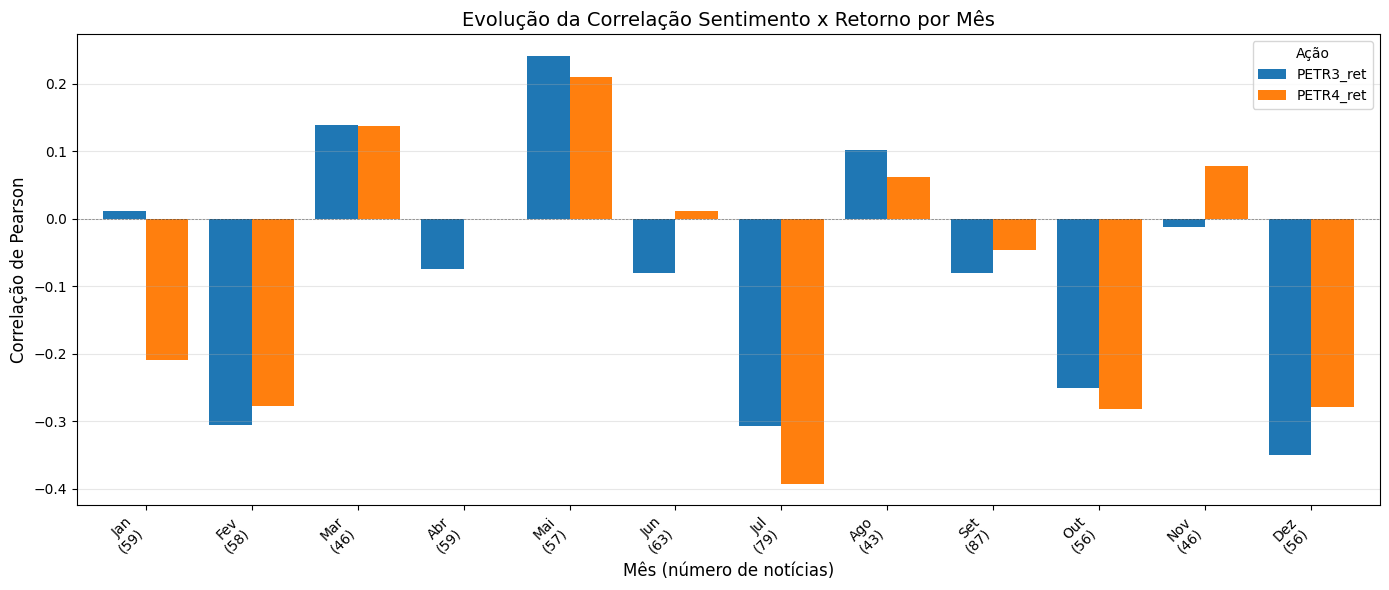


=== Correlações Estatisticamente Significativas (p < 0.05) ===
Empty DataFrame
Columns: [periodo, acao, correlacao, p_valor, n_observacoes, num_noticias, lag]
Index: []


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcular número de notícias por mês
news_by_month = merged.groupby(pd.Grouper(freq='M'))['count_news'].sum()

# Criar pivot para visualização
pivot = results_df.pivot(index='periodo', columns='acao', values='correlacao')

# Dicionário para traduzir meses abreviados
meses_pt = {
    1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Abr', 5: 'Mai', 6: 'Jun',
    7: 'Jul', 8: 'Ago', 9: 'Set', 10: 'Out', 11: 'Nov', 12: 'Dez'
}

# Criar labels personalizados
labels = []
for date in pivot.index:
    month_abbr = meses_pt[date.month]
    n_news = news_by_month.get(date, 0)
    labels.append(f"{month_abbr}\n({int(n_news)})")

# Gráfico de barras
fig, ax = plt.subplots(figsize=(14, 6))
pivot.plot(kind='bar', ax=ax, width=0.8)
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
plt.ylabel('Correlação de Pearson', fontsize=12)
plt.xlabel('Mês (número de notícias)', fontsize=12)
plt.title('Evolução da Correlação Sentimento x Retorno por Mês', fontsize=14)
plt.legend(title='Ação', fontsize=10)
ax.set_xticklabels(labels, rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Mostrar quais correlações são significativas (p < 0.05)
print("\n=== Correlações Estatisticamente Significativas (p < 0.05) ===")
sig_results = results_df[results_df['p_valor'] < 0.05]
print(sig_results.to_string(index=False))

# Análise do resultado dos sentimentos extraídos

Fazer a verificação de quantas notícias de cada sentimento foi gereado pelos modelos e verificar qual foi a sua correlação (porcentagem de notícias que tiveram o mesmo sentimento atribuído), com o intuito de entender a diferença entre os modelos e chegar a uma conclusão satisfatória.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("noticias_final_2024.csv", encoding='utf-8', decimal=',')

In [ ]:
lm = df["lm_sentimento"].value_counts()
xlm = df["xlm_sentimento"].value_counts()

print(lm)
print(xlm)

lm_sentimento
neutro      331
negativo    330
positivo     86
Name: count, dtype: int64
xlm_sentimento
neutral     349
negative    203
positive    195
Name: count, dtype: int64


In [ ]:
# verificar para todo o dataframe, qual foi a porcentagem de notícias que tiveram o mesmo sentimento atribuído por ambos os modelos
# calculando a concordância dos modelos

mapping = {
    "negative": "negativo",
    "positive": "positivo",
    "neutral": "neutro"
}

df["xlm_padronizado"] = df["xlm_sentimento"].map(mapping)

df["iguais"] = df["xlm_padronizado"] == df["lm_sentimento"]

quantidade_iguais = df["iguais"].sum()

print("Quantidade de notícias que coincidiram o sentimento nos dois modelos:")
print(quantidade_iguais)
print("Porcentagem de notícias que coincidiram o sentimento nos dois modelos:")
print((quantidade_iguais/len(df)) * 100)

# 4. Ver quantos iguais por tipo de sentimento
iguais_por_tipo = df[df["iguais"]]["xlm_padronizado"].value_counts()
print("\nDistribuição dos sentimentos iguais:")
print(iguais_por_tipo)



Quantidade de notícias que coincidiram o sentimento nos dois modelos:
311
Porcentagem de notícias que coincidiram o sentimento nos dois modelos:
41.633199464524765

Distribuição dos sentimentos iguais:
xlm_padronizado
neutro      145
negativo    131
positivo     35
Name: count, dtype: int64


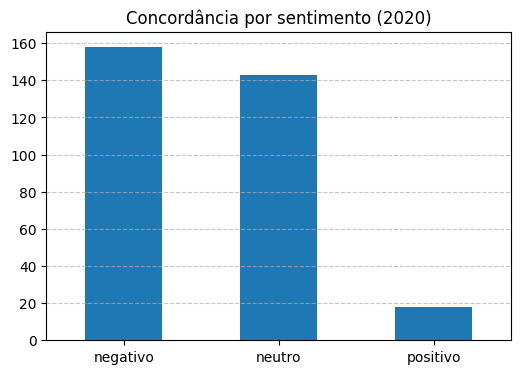

In [ ]:
# 7. Criar o gráfico de barras
plt.figure(figsize=(6, 4))
iguais_por_tipo.plot(kind='bar')

plt.title("Concordância por sentimento (2020)")
plt.xlabel("")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 8.Mostrar o gráfico
plt.show()

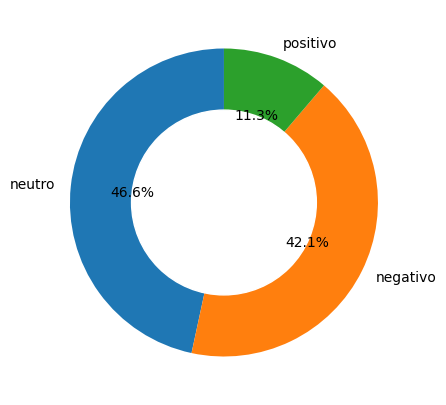

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
wedges, texts, autotexts = ax.pie(
    iguais_por_tipo, labels=iguais_por_tipo.index, autopct='%1.1f%%', startangle=90
)
# Cria o "furo" central
plt.Circle((0,0), 0.6, color='white')
ax.add_artist(plt.Circle((0,0), 0.6, color='white'))
plt.title("")
plt.show()

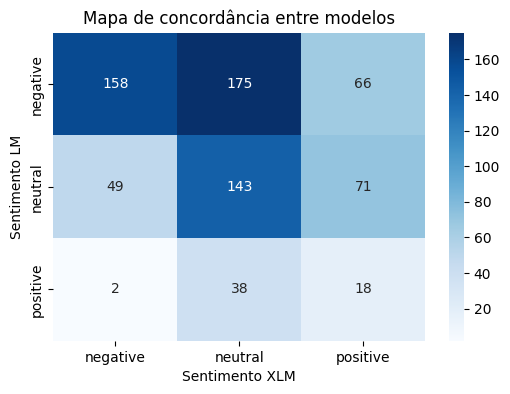

In [ ]:
# Cria tabela de contingência entre os modelos
matriz_confusao = pd.crosstab(df["lm_padronizado"], df["xlm_sentimento"])

plt.figure(figsize=(6,4))
sns.heatmap(matriz_confusao, annot=True, fmt="d", cmap="Blues")
plt.title("Mapa de concordância entre modelos")
plt.xlabel("Sentimento XLM")
plt.ylabel("Sentimento LM")
plt.show()

#Análise dos títulos por mês

In [ ]:
import pandas as pd

fn = "noticias_final_2020.csv"
df = pd.read_csv(fn, encoding='utf-8', decimal=',')

def filtrar_titulos_por_mes(df, mes):
  # Garante que a coluna 'data' é do tipo datetime
    df['data'] = pd.to_datetime(df['data'], errors='coerce')

    # Filtra as linhas cujo mês corresponde ao informado
    df_filtrado = df[df['data'].dt.month == mes]

    # Retorna os títulos como lista
    return df_filtrado[['titulo', 'xlm_sentimento']].to_dict(orient='records')



titulos = filtrar_titulos_por_mes(df, 9)
for t in titulos:
    print(t)

{'titulo': 'Ações da Petrobras chegam a cair quase 30% após preço do petróleo desabar', 'xlm_sentimento': 'negative'}
{'titulo': 'Processo de normalização da operação pode começar em julho, diz Petrobras', 'xlm_sentimento': 'neutral'}
{'titulo': 'Após mais de 800 casos de covid-19, Petrobras pode enfrentar ação do MPT', 'xlm_sentimento': 'neutral'}
{'titulo': 'Secretaria do Espírito Santo confirma 53 infectados na plataforma Macaé da Petrobras', 'xlm_sentimento': 'negative'}
{'titulo': 'Petrobras cancela datas de pagamento de dividendos com base no resultado de 2019', 'xlm_sentimento': 'negative'}
{'titulo': 'Petrobras perde mais de R$ 125 bilhões em valor na bolsa com tombo do petróleo', 'xlm_sentimento': 'negative'}
{'titulo': 'Petrobras: Justiça determina que siga arbitragem instaurada por Petros e Previ', 'xlm_sentimento': 'negative'}
{'titulo': 'Petrobras afirma que monitora mercado de petróleo enquanto ações afundam 25%', 'xlm_sentimento': 'negative'}
{'titulo': 'É cedo projetar 